In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report


# Model Evaluation on PlantVillage Dataset

This notebook evaluates the trained model using the test set. It includes metrics, confusion matrix, ROC curves, and a classification report.

In [2]:
# Load Trained Model and Test Data
model = keras.models.load_model('best_model_wo_augmentation.h5')  # or 'best_model_w_augmentation.h5' if used
import tensorflow_datasets as tfds
ds_info = tfds.builder('plant_village').info
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, ds_info.features['label'].num_classes)
ds_test = tfds.load('plant_village', split='train[95%:]', as_supervised=True)
test_ds = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
class_names = ds_info.features['label'].names


2025-07-18 11:11:55.550356: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-07-18 11:11:55.550389: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-07-18 11:11:55.550396: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2025-07-18 11:11:55.550428: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-18 11:11:55.550451: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# Generate Predictions on Test Set
y_true = []
y_pred = []
y_score = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)


2/2 [==============================] - 0s 6ms/step


2025-07-18 11:11:58.828290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 38ms/step


In [4]:
# Calculate Evaluation Metrics (Accuracy, Precision, Recall, F1)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.6873
Precision: 0.6861
Recall: 0.6873
F1-score: 0.6759


/Users/2mc/miniconda3/envs/daml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


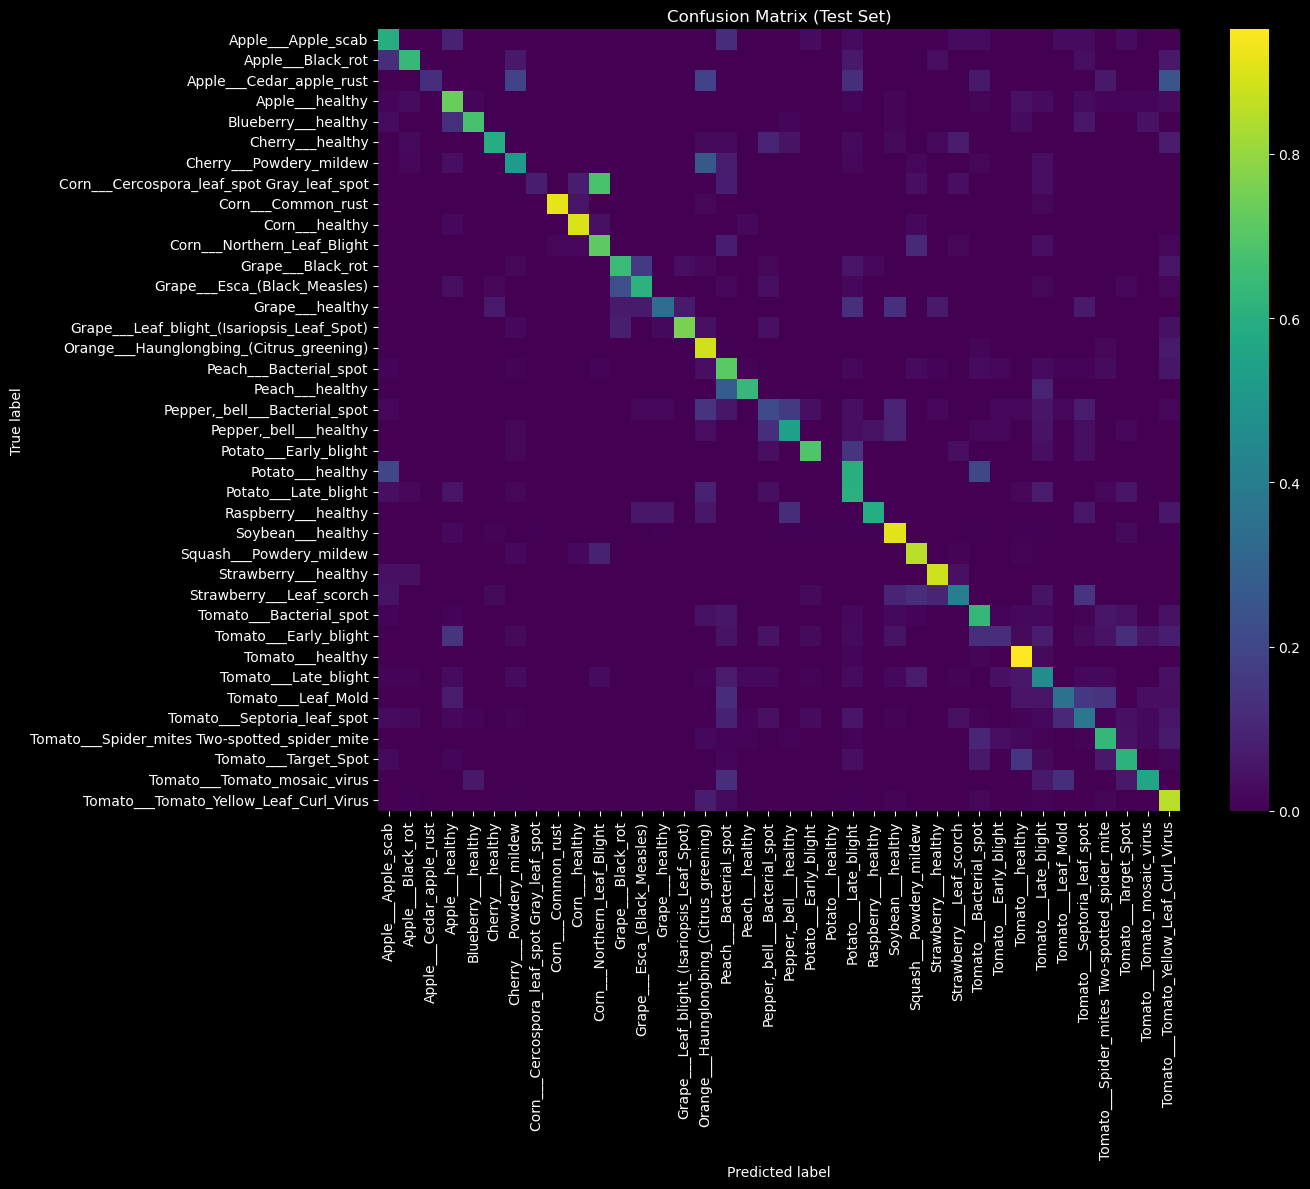

In [6]:
# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='.2f', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


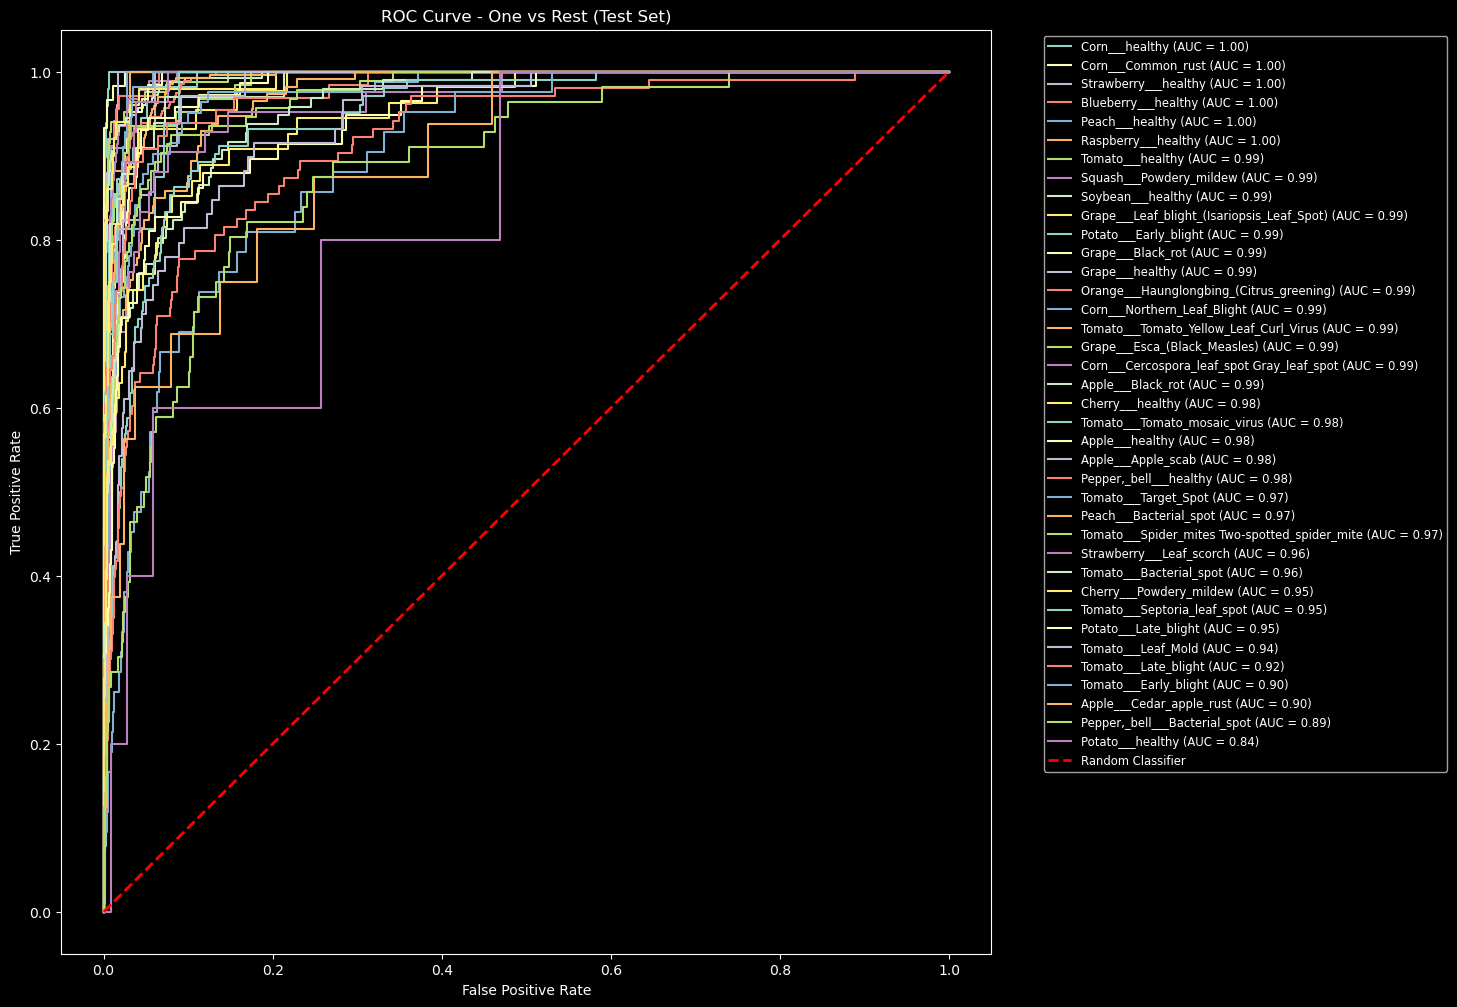

In [7]:
# Plot ROC Curves for Each Class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.eye(n_classes)[y_true][:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(np.eye(n_classes)[y_true][:, i], y_score[:, i])
plt.figure(figsize=(12, 12))
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)
for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [8]:
# Display Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.48      0.59      0.53        34
                            Apple___Black_rot       0.68      0.64      0.66        33
                     Apple___Cedar_apple_rust       1.00      0.12      0.22        16
                              Apple___healthy       0.56      0.74      0.63        72
                          Blueberry___healthy       0.94      0.68      0.79        68
                             Cherry___healthy       0.84      0.59      0.69        44
                      Cherry___Powdery_mildew       0.58      0.52      0.55        54
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.67      0.07      0.13        28
                           Corn___Common_rust       0.98      0.92      0.95        60
                               Corn___healthy       0.85      0.90      0.87        49
                  Corn___Northern_Leaf_Bli

/Users/2mc/miniconda3/envs/daml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/2mc/miniconda3/envs/daml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/2mc/miniconda3/envs/daml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
